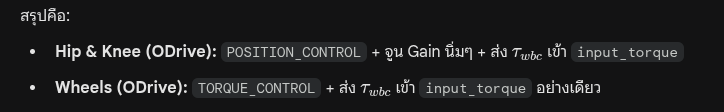

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Ascento-style WBC / ID-QP with sigma-based rolling contact + Full Dynamic Tasks (Pi 5 friendly).

Features:
  - Fast Analytic Rolling Constraint (No finite-difference, Sxz * (a_C + alpha * v_C) = 0)
  - Gain Scheduled LQR Pitch Task (Lookup Table to eliminate latency)
  - Robust Kinematic Limits & Posture Task (Safely handles both Revolute and Continuous wheel joints)
  - Safe Initial Posture initialization to avoid OSQP primal infeasibility
"""

import numpy as np
import pinocchio as pin
import osqp
from scipy import sparse
import scipy.linalg as la
import scipy.signal as signal


# =========================================================
# Math utils
# =========================================================
def skew(v):
    v = np.asarray(v, dtype=float).reshape(3)
    vx, vy, vz = v
    return np.array([[0.0, -vz,  vy],
                     [vz,  0.0, -vx],
                     [-vy, vx,  0.0]], dtype=float)

def normalize(v, eps=1e-12):
    v = np.asarray(v, dtype=float).reshape(-1)
    n = np.linalg.norm(v)
    if n < eps:
        return np.zeros_like(v)
    return v / n

def require_frame_id(model: pin.Model, frame_name: str) -> int:
    fid = model.getFrameId(frame_name)
    if fid == len(model.frames):
        cand = [f.name for f in model.frames[:120]]
        raise ValueError(f"Frame '{frame_name}' not found. Example frames: {cand}")
    return fid

def require_joint_id(model: pin.Model, joint_name: str) -> int:
    jid = model.getJointId(joint_name)
    if jid == 0:
        raise ValueError(f"Joint '{joint_name}' not found. Available: {model.names}")
    return jid

def wrap_pi(a):
    return (a + np.pi) % (2*np.pi) - np.pi

def rpy_from_R_zyx(R):
    sp = -R[2, 0]
    sp = np.clip(sp, -1.0, 1.0)
    pitch = np.arcsin(sp)

    if abs(np.cos(pitch)) < 1e-9:
        roll = 0.0
        yaw = np.arctan2(-R[0,1], R[1,1])
    else:
        roll = np.arctan2(R[2,1], R[2,2])
        yaw  = np.arctan2(R[1,0], R[0,0])

    return np.array([roll, pitch, yaw], dtype=float)


# =========================================================
# Model helpers
# =========================================================
def load_model(urdf_path: str, use_free_flyer: bool = True):
    if use_free_flyer:
        model = pin.buildModelFromUrdf(urdf_path, pin.JointModelFreeFlyer())
    else:
        model = pin.buildModelFromUrdf(urdf_path)
    data = model.createData()
    return model, data

def set_freeflyer_pose(model: pin.Model, q: np.ndarray,
                       position_xyz=(0.0, 0.0, 0.0),
                       quat_xyzw=(0.0, 0.0, 0.0, 1.0)):
    q[0:3] = np.array(position_xyz, dtype=float)
    quat = np.array(quat_xyzw, dtype=float)
    quat = quat / (np.linalg.norm(quat) + 1e-12)
    q[3:7] = quat

def set_joint_position_by_name(model: pin.Model, q: np.ndarray, joint_name: str, value: float):
    jid = require_joint_id(model, joint_name)
    iq = model.idx_qs[jid]
    q[iq] = float(value)

def set_joint_velocity_by_name(model: pin.Model, u: np.ndarray, joint_name: str, value: float):
    jid = require_joint_id(model, joint_name)
    iv = model.idx_vs[jid]
    u[iv] = float(value)


# =========================================================
# Dynamic Ascento Task Helpers (LQR LUT)
# =========================================================
class LQRLookupTable:
    def __init__(self, L_min=0.1, L_max=0.6, num_points=100, 
                 g=9.81, dt=0.0025, Q=None, R=None):
        if Q is None:
            Q = np.diag([100.0, 10.0, 50.0])
        if R is None:
            R = np.array([[1.0]])
            
        self.L_array = np.linspace(L_min, L_max, num_points)
        self.K_array = np.zeros((num_points, 3))
        
        for i, L in enumerate(self.L_array):
            a31 = -g
            a32 = 0.0
            b31 = L

            Ac = np.array([
                [0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0],
                [a31, a32, 0.0]
            ])
            Bc = np.array([
                [0.0],
                [1.0],
                [b31]
            ])
            Cc = np.eye(3)
            Dc = np.zeros((3, 1))

            sys_d = signal.cont2discrete((Ac, Bc, Cc, Dc), dt, method='zoh')
            Ad, Bd = sys_d[0], sys_d[1]

            P = la.solve_discrete_are(Ad, Bd, Q, R)
            K = np.linalg.inv(R + Bd.T @ P @ Bd) @ (Bd.T @ P @ Ad)
            self.K_array[i, :] = K.flatten()

    def get_gains(self, L_current):
        k_th = np.interp(L_current, self.L_array, self.K_array[:, 0])
        k_thd = np.interp(L_current, self.L_array, self.K_array[:, 1])
        k_v = np.interp(L_current, self.L_array, self.K_array[:, 2])
        return np.array([k_th, k_thd, k_v])

def compute_zmp_roll_reference(v_forward, yaw_rate, g=9.81):
    return np.arctan2(v_forward * yaw_rate, g)

def compute_adjusted_height_reference(L_ref, theta_pitch, phi_roll):
    return L_ref * np.cos(theta_pitch) * np.cos(phi_roll)


# =========================================================
# Ascento sigma-based contact geometry
# =========================================================
def sigma_from_ground_normal(n_I: np.ndarray, R_IW: np.ndarray) -> float:
    n_I = normalize(n_I)
    R_WI = R_IW.T
    x = R_WI @ n_I
    return float(np.arctan2(x[0], x[2]))

def sigma_dot_from_omega(n_I: np.ndarray, R_IW: np.ndarray, omega_IW_I: np.ndarray) -> float:
    n_I = normalize(n_I)
    R_WI = R_IW.T
    x = R_WI @ n_I
    omega_W = R_WI @ omega_IW_I
    x_dot = -np.cross(omega_W, x)
    denom = x[0]**2 + x[2]**2
    if denom < 1e-12: return 0.0
    return float((x[2] * x_dot[0] - x[0] * x_dot[2]) / denom)

def r_WC_in_W(sigma: float, rho: float) -> np.ndarray:
    return np.array([rho * np.sin(sigma), 0.0, rho * np.cos(sigma)], dtype=float)

def dr_WC_dsigma_in_W(sigma: float, rho: float) -> np.ndarray:
    return np.array([rho * np.cos(sigma), 0.0, -rho * np.sin(sigma)], dtype=float)

def axis_from_frame_rotation(R_world_frame: np.ndarray, local_axis: str) -> np.ndarray:
    if local_axis == "x": return R_world_frame[:, 0]
    if local_axis == "y": return R_world_frame[:, 1]
    if local_axis == "z": return R_world_frame[:, 2]
    raise ValueError("local_axis must be one of {'x','y','z'}")

def build_contact_frame_R_CI(n_I: np.ndarray, wheel_forward_I: np.ndarray) -> np.ndarray:
    z = normalize(n_I)
    f = wheel_forward_I - (z @ wheel_forward_I) * z
    x = normalize(f)
    if np.linalg.norm(x) < 1e-9:
        ex = np.array([1.0, 0.0, 0.0])
        x = normalize(ex - (z @ ex) * z)
    y = normalize(np.cross(z, x))
    x = normalize(np.cross(y, z))
    return np.column_stack((x, y, z)).T


# =========================================================
# Control frame N
# =========================================================
def build_control_frame_N(pC_L_I, pC_R_I, heading_I, n_I=np.array([0.0,0.0,1.0])):
    n_I = normalize(n_I)
    y = normalize(pC_R_I - pC_L_I)
    h = normalize(heading_I - (n_I @ heading_I) * n_I)
    x = normalize(h - (y @ h) * y)
    if np.linalg.norm(x) < 1e-9:
        x = normalize(np.array([1.0,0.0,0.0]) - (y @ np.array([1.0,0.0,0.0])) * y)
    z = normalize(np.cross(x, y))
    if z @ n_I < 0.0:
        z = -z
        x = -x
    pG_I = 0.5 * (pC_L_I + pC_R_I)
    return np.column_stack((x, y, z)), pG_I

def compute_heading_from_base(model, data, base_frame, n_I):
    R_IB = data.oMf[require_frame_id(model, base_frame)].rotation
    h = R_IB[:, 0]
    return normalize(h - (n_I @ h) * n_I)


# =========================================================
# Fast analytic rolling contact (NO FD)
# =========================================================
def wheel_contact_kinematics_fast(model, data, q, v, wheel_frame: str, rho: float,
                                  n_world: np.ndarray, wheel_forward_axis_local: str,
                                  ref=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED):
    fid = require_frame_id(model, wheel_frame)
    oMw = data.oMf[fid]
    p_IW = oMw.translation.copy()
    R_IW = oMw.rotation.copy()

    fwd_I = axis_from_frame_rotation(R_IW, wheel_forward_axis_local)
    R_CI = build_contact_frame_R_CI(n_world, fwd_I)
    R_IC = R_CI.T

    J6 = pin.getFrameJacobian(model, data, fid, ref)
    v6 = pin.getFrameVelocity(model, data, fid, ref)
    a6 = pin.getFrameClassicalAcceleration(model, data, fid, ref)

    sigma = sigma_from_ground_normal(n_world, R_IW)
    sigma_dot = sigma_dot_from_omega(n_world, R_IW, v6.angular)

    r_W  = r_WC_in_W(sigma, rho)
    dr_W = dr_WC_dsigma_in_W(sigma, rho)

    r_I = R_IW @ r_W
    if (r_I @ normalize(n_world)) > 0.0:
        r_I = -r_I
        dr_W = -dr_W

    t_I = R_IW @ dr_W

    Jv = J6[0:3, :]
    Jw = J6[3:6, :]
    Jc_I = Jv + skew(r_I) @ Jw

    v_c_I = v6.linear + np.cross(v6.angular, r_I) + t_I * sigma_dot

    a_c0_I = (
        a6.linear
        + np.cross(a6.angular, r_I)
        + np.cross(v6.angular, np.cross(v6.angular, r_I))
        + np.cross(v6.angular, t_I * sigma_dot)
    )

    return dict(wheel_frame=wheel_frame, R_CI=R_CI, R_IC=R_IC, r_I=r_I, p_IW=p_IW,
                p_IC=p_IW + r_I, Jc_I=Jc_I, v_c_I=v_c_I, a_c0_I=a_c0_I,
                sigma=sigma, sigma_dot=sigma_dot)

def build_rolling_constraints_fast(model, data, q, u, wheel_frames: dict, rho: float,
                                   n_world: np.ndarray, wheel_forward_axis_local: str,
                                   alpha_bg: float = 50.0,
                                   ref=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED):
    v = u.copy()
    pin.forwardKinematics(model, data, q, v, np.zeros_like(v))
    pin.computeJointJacobians(model, data, q)
    pin.updateFramePlacements(model, data)

    Sxz = np.array([[1.0, 0.0, 0.0],
                    [0.0, 0.0, 1.0]], dtype=float)

    A_list, rhs_list, contacts = [], [], []

    for side in ["left", "right"]:
        info = wheel_contact_kinematics_fast(model, data, q, v,
                                             wheel_frames[side], rho, n_world,
                                             wheel_forward_axis_local, ref)
        contacts.append(info)

        Jc_C   = info["R_CI"] @ info["Jc_I"]
        v_c_C  = info["R_CI"] @ info["v_c_I"]
        a0_c_C = info["R_CI"] @ info["a_c0_I"]

        A_sel = Sxz @ Jc_C
        rhs_sel = -(Sxz @ (a0_c_C + alpha_bg * v_c_C))

        A_list.append(A_sel)
        rhs_list.append(rhs_sel.reshape(-1))

    return np.vstack(A_list), np.hstack(rhs_list).reshape(-1), contacts


# =========================================================
# Actuation selection & Costs
# =========================================================
def build_actuation_selection(model: pin.Model):
    nv = model.nv
    na = nv - 6
    S = np.zeros((na, nv), dtype=float)
    for i in range(na):
        S[i, 6 + i] = 1.0
    return S, na

def add_least_squares_cost(H, g, A_full, b, w):
    if w > 0.0:
        H += w * (A_full.T @ A_full)
        g += -w * (A_full.T @ b)
    return H, g


# =========================================================
# Tasks definition (Robust against continuous joints)
# =========================================================
def build_base_height_task_N(model, data, q, u, base_frame, R_IN, pG_I, z_ref, kp, kd,
                             ref=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED):
    fid = require_frame_id(model, base_frame)
    p_NB = R_IN.T @ (data.oMf[fid].translation - pG_I)
    v_NB = R_IN.T @ pin.getFrameVelocity(model, data, fid, ref).linear
    a0_NB = R_IN.T @ pin.getFrameClassicalAcceleration(model, data, fid, ref).linear

    zdd_des = kp*(z_ref - float(p_NB[2])) - kd*float(v_NB[2])
    Jv = pin.getFrameJacobian(model, data, fid, ref)[0:3, :]
    A = np.array([[0.0, 0.0, 1.0]]) @ (R_IN.T @ Jv)
    b = np.array([zdd_des - float(np.array([0.0,0.0,1.0]) @ a0_NB)], dtype=float)
    return A, b

def build_base_roll_task_N(model, data, q, u, base_frame, R_IN, roll_ref, kp, kd,
                           ref=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED):
    fid = require_frame_id(model, base_frame)
    R_NB = R_IN.T @ data.oMf[fid].rotation
    roll = float(rpy_from_R_zyx(R_NB)[0])
    omega_N = R_IN.T @ pin.getFrameVelocity(model, data, fid, ref).angular
    alpha0_N = R_IN.T @ pin.getFrameClassicalAcceleration(model, data, fid, ref).angular

    roll_dot = float(omega_N[0])
    rolldd_des = kp*(roll_ref - roll) - kd*roll_dot
    Jw = pin.getFrameJacobian(model, data, fid, ref)[3:6, :]
    A = np.array([[1.0, 0.0, 0.0]]) @ (R_IN.T @ Jw)
    b = np.array([rolldd_des - float(np.array([1.0,0.0,0.0]) @ alpha0_N)], dtype=float)
    return A, b, roll, roll_dot

def build_base_yaw_task_N(model, data, q, u, base_frame, R_IN, yaw_ref, kp, kd,
                          ref=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED):
    fid = require_frame_id(model, base_frame)
    yaw = float(wrap_pi(rpy_from_R_zyx(R_IN.T @ data.oMf[fid].rotation)[2]))
    omega_N = R_IN.T @ pin.getFrameVelocity(model, data, fid, ref).angular
    alpha0_N = R_IN.T @ pin.getFrameClassicalAcceleration(model, data, fid, ref).angular

    yaw_dot = float(omega_N[2])
    yawdd_des = kp*(wrap_pi(yaw_ref - yaw)) - kd*yaw_dot
    Jw = pin.getFrameJacobian(model, data, fid, ref)[3:6, :]
    A = np.array([[0.0, 0.0, 1.0]]) @ (R_IN.T @ Jw)
    b = np.array([yawdd_des - float(np.array([0.0,0.0,1.0]) @ alpha0_N)], dtype=float)
    return A, b, yaw, yaw_dot

def build_lqr_pitch_task_N_simple(model, data, q, u, base_frame, R_IN, v_xN,
                                  theta_ref, thetad_ref, v_ref, K_lqr,
                                  ref=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED):
    fid = require_frame_id(model, base_frame)
    theta = float(rpy_from_R_zyx(R_IN.T @ data.oMf[fid].rotation)[1])
    omega_N = R_IN.T @ pin.getFrameVelocity(model, data, fid, ref).angular
    alpha0_N = R_IN.T @ pin.getFrameClassicalAcceleration(model, data, fid, ref).angular

    thetad = float(omega_N[1])
    thetadd_des = (K_lqr[0]*(theta_ref - theta)
                   + K_lqr[1]*(thetad_ref - thetad)
                   + K_lqr[2]*(v_ref - v_xN))

    Jw = pin.getFrameJacobian(model, data, fid, ref)[3:6, :]
    A = np.array([[0.0, 1.0, 0.0]]) @ (R_IN.T @ Jw)
    b = np.array([thetadd_des - float(np.array([0.0,1.0,0.0]) @ alpha0_N)], dtype=float)
    return A, b, theta, thetad

def build_posture_task(model, q, u, q_ref_actuated, kp=50.0, kd=10.0):
    """
    ปลอดภัยต่อโมเดลที่มี Continuous Joints (ล้อ) 
    โดยล้อจะถูก Damping แค่ความเร็ว ไม่โดนดึงกลับไปที่ตำแหน่งศูนย์
    """
    na = model.nv - 6
    A = np.zeros((na, model.nv), dtype=float)
    qdd_des = np.zeros(na)
    
    act_idx = 0
    for joint_id in range(1, model.njoints):
        joint = model.joints[joint_id]
        if joint.nv != 1:  # ข้าม Free-flyer
            continue
            
        iq = joint.idx_q
        iv = joint.idx_v
        
        if joint.nq == 1:
            # ข้อต่อแบบ Revolute (สะโพก, เข่า) -> ใช้ PD Control ปกติ
            err = q_ref_actuated[act_idx] - q[iq]
            qdd_des[act_idx] = kp * err - kd * u[iv]
        else:
            # ข้อต่อแบบ Continuous (ล้อ) -> ใส่แค่ Damping ป้องกันล้อหมุนฟรีแรงเกินไป
            qdd_des[act_idx] = -kd * u[iv]
            
        A[act_idx, iv] = 1.0
        act_idx += 1
        
    return A, qdd_des


# =========================================================
# Main Full Dynamic ID-QP (พร้อม Kinematic Limits ที่ปลอดภัย)
# =========================================================
def solve_wbc_idqp_full_dynamic(model, data, q, u, wheel_frames: dict,
                                lqr_lut: LQRLookupTable,
                                rho=0.07, mu=0.6, tau_limit=40.0, alpha_bg=50.0,
                                wheel_forward_axis_local="x", n_world=np.array([0.0, 0.0, 1.0]),
                                base_frame="base_link",
                                dt=0.0025,
                                target_L_pendulum=0.40,
                                yaw_ref=0.0, theta_ref=0.0, thetad_ref=0.0, v_ref=0.0,
                                q_ref_actuated=None,
                                kp_z=200.0, kd_z=40.0, kp_roll=200.0, kd_roll=40.0,
                                kp_yaw=50.0, kd_yaw=10.0, kp_post=50.0, kd_post=10.0,
                                w_height=80.0, w_roll=80.0, w_lqr_pitch=120.0,
                                w_yaw=10.0, w_posture=2.0, w_ddq=1.0, w_tau=1e-4, w_f=1e-4):

    nv = model.nv
    S, na = build_actuation_selection(model)
    
    # สร้าง q_ref_actuated อัตโนมัติหากไม่ได้กำหนดมา (เก็บเฉพาะ Joint ที่มี nq=1)
    if q_ref_actuated is None:
        q_ref_actuated = np.zeros(na)
        act_idx = 0
        for joint_id in range(1, model.njoints):
            joint = model.joints[joint_id]
            if joint.nv == 1:
                if joint.nq == 1:
                    q_ref_actuated[act_idx] = q[joint.idx_q]
                act_idx += 1

    # Full dynamics
    pin.computeAllTerms(model, data, q, u)
    M = data.M.copy()
    h = data.nle.copy()

    # ----- Rolling constraints -----
    Aroll, rhs_roll, contacts = build_rolling_constraints_fast(
        model, data, q, u, wheel_frames,
        rho=rho, n_world=n_world,
        wheel_forward_axis_local=wheel_forward_axis_local,
        alpha_bg=alpha_bg
    )
    nc = len(contacts)
    Jc = np.vstack([c["Jc_I"] for c in contacts])

    Rblk = np.zeros((3*nc, 3*nc), dtype=float)
    for i in range(nc):
        Rblk[3*i:3*i+3, 3*i:3*i+3] = contacts[i]["R_IC"]

    n_f = 3 * nc
    n_x = nv + na + n_f
    idx_ddq0 = 0
    idx_tau0 = nv
    idx_f0 = nv + na

    # ----- Hard equalities -----
    A_dyn = np.zeros((nv, n_x), dtype=float)
    A_dyn[:, idx_ddq0:idx_ddq0+nv] = M
    A_dyn[:, idx_tau0:idx_tau0+na] = -S.T
    A_dyn[:, idx_f0:idx_f0+n_f] = -(Jc.T @ Rblk)

    A_roll = np.zeros((Aroll.shape[0], n_x), dtype=float)
    A_roll[:, idx_ddq0:idx_ddq0+nv] = Aroll

    Aeq = np.vstack([A_dyn, A_roll])
    beq = np.hstack([-h, rhs_roll])

    # ----- Inequalities -----
    
    # 1. Torque limits
    A_tau = np.zeros((na, n_x), dtype=float)
    for i in range(na):
        A_tau[i, idx_tau0 + i] = 1.0

    # 2. Friction pyramid
    A_fric = np.zeros((5 * nc, n_x), dtype=float)
    row = 0
    for i in range(nc):
        base = idx_f0 + 3*i
        A_fric[row:row+2, base+0] = np.array([1.0, -1.0])
        A_fric[row:row+2, base+2] = -mu
        row += 2
        A_fric[row:row+2, base+1] = np.array([1.0, -1.0])
        A_fric[row:row+2, base+2] = -mu
        row += 2
        A_fric[row, base+2] = -1.0
        row += 1

    # 3. Kinematic Limits (Position & Velocity via Velocity Damper)
    A_kin = np.zeros((na, n_x), dtype=float)
    ddq_lb = np.zeros(na)
    ddq_ub = np.zeros(na)
    
    kp_limit = 20.0
    actuated_idx = 0 
    
    for joint_id in range(1, model.njoints):
        joint = model.joints[joint_id]
        if joint.nv != 1:
            continue
            
        iq = joint.idx_q
        iv = joint.idx_v
        
        qi = q[iq] 
        vi = u[iv]
        
        q_min = model.lowerPositionLimit[iq]
        q_max = model.upperPositionLimit[iq]
        v_max_urdf = model.velocityLimit[iv]
        
        if v_max_urdf <= 1e-4:
            v_max_urdf = 100.0
        v_min_urdf = -v_max_urdf
        
        is_continuous = (joint.nq == 2) or (abs(q_max - q_min) < 1e-4) or (q_max > 1e4) or (q_min < -1e4)

        if is_continuous:
            v_allowed_max = v_max_urdf
            v_allowed_min = v_min_urdf
        else:
            v_allowed_max = min(v_max_urdf, kp_limit * (q_max - qi))
            v_allowed_min = max(v_min_urdf, kp_limit * (q_min - qi))
            
        A_kin[actuated_idx, idx_ddq0 + iv] = 1.0  
        
        ddq_ub[actuated_idx] = (v_allowed_max - vi) / dt
        ddq_lb[actuated_idx] = (v_allowed_min - vi) / dt

        if ddq_lb[actuated_idx] > ddq_ub[actuated_idx]:
            avg_ddq = 0.5 * (ddq_lb[actuated_idx] + ddq_ub[actuated_idx])
            ddq_lb[actuated_idx] = avg_ddq
            ddq_ub[actuated_idx] = avg_ddq
            
        actuated_idx += 1

    Aineq = np.vstack([A_tau, A_fric, A_kin])
    l_ineq = np.hstack([
        -tau_limit * np.ones(na),
        -np.inf * np.ones(5 * nc),
        ddq_lb
    ])
    u_ineq = np.hstack([
        tau_limit * np.ones(na),
        np.zeros(5 * nc),
        ddq_ub
    ])

    # ----- Objective -----
    H = np.zeros((n_x, n_x), dtype=float)
    g_obj = np.zeros(n_x)

    H[idx_ddq0:idx_ddq0+nv, idx_ddq0:idx_ddq0+nv] += w_ddq * np.eye(nv)
    H[idx_tau0:idx_tau0+na, idx_tau0:idx_tau0+na] += w_tau * np.eye(na)
    H[idx_f0:idx_f0+n_f, idx_f0:idx_f0+n_f] += w_f * np.eye(n_f)

    # ----- Frame N -----
    pin.forwardKinematics(model, data, q, u, np.zeros_like(u))
    pin.updateFramePlacements(model, data)

    heading_I = compute_heading_from_base(model, data, base_frame, normalize(n_world))
    R_IN, pG_I = build_control_frame_N(contacts[0]["p_IC"], contacts[1]["p_IC"],
                                       heading_I, normalize(n_world))

    v_xN = 0.5 * float((R_IN.T @ contacts[0]["v_c_I"])[0] + (R_IN.T @ contacts[1]["v_c_I"])[0])

    base_fid = require_frame_id(model, base_frame)
    R_NB = R_IN.T @ data.oMf[base_fid].rotation
    current_roll, current_pitch, _ = rpy_from_R_zyx(R_NB)

    omega_N = R_IN.T @ pin.getFrameVelocity(model, data, base_fid, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED).angular
    yaw_rate = float(omega_N[2])

    # Tasks
    adjusted_z_ref = compute_adjusted_height_reference(target_L_pendulum, current_pitch, current_roll)
    A_h, b_h = build_base_height_task_N(model, data, q, u, base_frame, R_IN, pG_I, adjusted_z_ref, kp_z, kd_z)
    A_full = np.zeros((A_h.shape[0], n_x), dtype=float)
    A_full[:, idx_ddq0:idx_ddq0+nv] = A_h
    H, g_obj = add_least_squares_cost(H, g_obj, A_full, b_h, w_height)

    dynamic_roll_ref = compute_zmp_roll_reference(v_xN, yaw_rate)
    A_r, b_r, _, _ = build_base_roll_task_N(model, data, q, u, base_frame, R_IN, dynamic_roll_ref, kp_roll, kd_roll)
    A_full = np.zeros((A_r.shape[0], n_x), dtype=float)
    A_full[:, idx_ddq0:idx_ddq0+nv] = A_r
    H, g_obj = add_least_squares_cost(H, g_obj, A_full, b_r, w_roll)

    online_K_lqr = lqr_lut.get_gains(target_L_pendulum)
    A_p, b_p, _, _ = build_lqr_pitch_task_N_simple(model, data, q, u, base_frame, R_IN, v_xN, theta_ref, thetad_ref, v_ref, online_K_lqr)
    A_full = np.zeros((A_p.shape[0], n_x), dtype=float)
    A_full[:, idx_ddq0:idx_ddq0+nv] = A_p
    H, g_obj = add_least_squares_cost(H, g_obj, A_full, b_p, w_lqr_pitch)

    A_y, b_y, _, _ = build_base_yaw_task_N(model, data, q, u, base_frame, R_IN, yaw_ref, kp_yaw, kd_yaw)
    A_full = np.zeros((A_y.shape[0], n_x), dtype=float)
    A_full[:, idx_ddq0:idx_ddq0+nv] = A_y
    H, g_obj = add_least_squares_cost(H, g_obj, A_full, b_y, w_yaw)

    if w_posture > 0.0:
        A_post, b_post = build_posture_task(model, q, u, q_ref_actuated, kp_post, kd_post)
        A_full = np.zeros((A_post.shape[0], n_x), dtype=float)
        A_full[:, idx_ddq0:idx_ddq0+nv] = A_post
        H, g_obj = add_least_squares_cost(H, g_obj, A_full, b_post, w_posture)

    # ----- Solve OSQP -----
    prob = osqp.OSQP()
    A_osqp = sparse.csc_matrix(np.vstack([Aeq, Aineq]))
    l_osqp = np.hstack([beq, l_ineq])
    u_osqp = np.hstack([beq, u_ineq])

    prob.setup(P=sparse.csc_matrix((H + H.T) * 0.5),
               q=g_obj,
               A=A_osqp,
               l=l_osqp,
               u=u_osqp,
               verbose=False,
               polish=True,
               eps_abs=1e-7,
               eps_rel=1e-7)

    res = prob.solve()
    if res.info.status_val not in (1, 2):
        raise RuntimeError(f"OSQP failed: {res.info.status}")

    x = res.x
    ddq = x[idx_ddq0:idx_ddq0+nv]
    tau = x[idx_tau0:idx_tau0+na]
    fC = x[idx_f0:idx_f0+n_f].reshape(nc, 3)

    dyn_res = (A_dyn @ x + h)
    roll_res = (A_roll @ x - rhs_roll)

    return dict(
        ddq=ddq,
        tau=tau,
        fC=fC,
        dyn_res=dyn_res,
        roll_res=roll_res,
        K_lqr=online_K_lqr,
        adjusted_z_ref=adjusted_z_ref,
        dynamic_roll_ref=dynamic_roll_ref
    )

# =========================================================
# Execution (test)
# =========================================================
if __name__ == "__main__":
    urdf_path = "/home/xero/Ambula/robot_ws/src/ambula_simulation/ambula_description/urdf/ambula_bot_v3/ambula.urdf"

    try:
        model, data = load_model(urdf_path, use_free_flyer=True)
        q = pin.neutral(model)
        u = np.zeros(model.nv)

        # 1. Initialize LQR Lookup Table
        print("Initializing LQR Table...")
        lqr_table = LQRLookupTable(L_min=0.1, L_max=0.6, num_points=100, dt=0.0025)
        print("LQR Table Ready.")

        # จัดท่าเริ่มต้นของ Base
        set_freeflyer_pose(model, q, position_xyz=(0.0, 0.0, 0.4))

        # --- FIX: จัดท่าเริ่มต้นของ Joint ให้อยู่ในช่วง Limits ---
        # เลือกค่ามุมที่อยู่กึ่งกลางหรือค่าที่ต้องการให้หุ่นยืน
        hip_init_angle = 1.5   # อยู่ระหว่าง 1.134 ถึง 3.141
        knee_init_angle = 2.0  # อยู่ระหว่าง 1.570 ถึง 2.530
        
        try:
            set_joint_position_by_name(model, q, "left_hip_joint", hip_init_angle)
            set_joint_position_by_name(model, q, "right_hip_joint", hip_init_angle)
            set_joint_position_by_name(model, q, "left_knee_joint", knee_init_angle)
            set_joint_position_by_name(model, q, "right_knee_joint", knee_init_angle)
        except Exception as e:
            print(f"Warning: Could not set initial joint positions by name. Error: {e}")

        # สร้าง q_ref_actuated สำหรับ Posture Task ให้ตรงกับท่าเริ่มต้น
        _, na = build_actuation_selection(model)
        q_ref_actuated = np.zeros(na)
        act_idx = 0
        for joint_id in range(1, model.njoints):
            joint = model.joints[joint_id]
            if joint.nv == 1:
                if joint.nq == 1:
                    q_ref_actuated[act_idx] = q[joint.idx_q]
                act_idx += 1

        # เซ็ตความเร็วเริ่มต้นให้ล้อหมุน (อ้างอิงตามชื่อข้อต่อที่ปลอดภัยที่สุด)
        try:
            set_joint_velocity_by_name(model, u, "left_wheel_joint", 5.0)
            set_joint_velocity_by_name(model, u, "right_wheel_joint", 5.0)
        except Exception as e:
            print(f"Set velocity by name failed, trying raw index: {e}")
            if model.nv > 13:
                u[9], u[13] = 5.0, 5.0

        # 2. Control Loop
        out = solve_wbc_idqp_full_dynamic(
            model, data, q, u,
            wheel_frames={"left": "left_wheel_link", "right": "right_wheel_link"},
            lqr_lut=lqr_table, 
            target_L_pendulum=0.30,
            rho=0.07, mu=0.6, tau_limit=40.0,
            alpha_bg=50.0,
            v_ref=3.0,
            q_ref_actuated=q_ref_actuated # <-- ส่งค่านี้เข้าไปเพื่อรักษาท่าเริ่มต้น
        )

        np.set_printoptions(suppress=True, formatter={'float_kind': '{:.6f}'.format})

        print("\n=== Ascento-like ID-QP + FAST rolling constraint + LQR LUT (Pi 5) ===")
        print("Computed tau:", out["tau"])
        print("Contact forces fC (per contact, in C frame):\n", out["fC"])
        print("Online LQR Gains [k_th, k_thd, k_v]:", out["K_lqr"])
        print("Dynamic Roll Ref (rad):", out["dynamic_roll_ref"])
        print("Adjusted Height Ref (m):", out["adjusted_z_ref"])
        print("Dynamics residual norm:", np.linalg.norm(out["dyn_res"]))
        print("Rolling residual norm:", np.linalg.norm(out["roll_res"]))

    except Exception as e:
        print(f"Make sure URDF exists and names match. Error: {e}")

Initializing LQR Table...
LQR Table Ready.

=== Ascento-like ID-QP + FAST rolling constraint + LQR LUT (Pi 5) ===
Computed tau: [-1.293732 -6.562179 -11.001315 -1.825178 0.608698 8.459484 3.350782
 1.802075]
Contact forces fC (per contact, in C frame):
 [[-32.143899 -32.143899 53.573165]
 [28.675565 -28.675565 47.792608]]
Online LQR Gains [k_th, k_thd, k_v]: [41.669004 11.959829 -6.983797]
Dynamic Roll Ref (rad): -0.0
Adjusted Height Ref (m): 0.3
Dynamics residual norm: 2.679671459448586e-14
Rolling residual norm: 3.752248922430865e-15
